In [96]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data as data
from torch.utils.data import Dataset
import plotly.express as px

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [39]:
torch.manual_seed(42)

In [73]:
df = pd.read_csv('TimeSeries.csv')

In [74]:
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df.drop(['Year','Month'],axis=1,inplace=True)
df.rename(columns = {' Sales':'Sales'}, inplace = True)
df["Sales"] = pd.to_numeric(df["Sales"].str.replace(',', ''))
df.set_index('Date',inplace=True)

In [72]:
df

,Sales
Date,
2005-01-01,10827
2005-02-01,12049
2005-03-01,18298
2005-04-01,17834
2005-05-01,16480
...,...
2017-05-01,31739
2017-06-01,30315
2017-07-01,25046


In [75]:
from sklearn.preprocessing import StandardScaler

# Fit scalers
scalers = {}
for x in df.columns:
  scalers[x] = StandardScaler().fit(df[x].values.reshape(-1, 1))

# Transform data via scalers
norm_df = df.copy()
for i, key in enumerate(scalers.keys()):
  norm = scalers[key].transform(norm_df.iloc[:, i].values.reshape(-1, 1))
  norm_df.iloc[:, i] = norm

In [62]:
# Defining a function that creates sequences and targets as shown above
def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, drop_targets=False):
  # df: Pandas DataFrame of the univariate time-series
  # btw: Training Window - Integer defining how many steps to look back
  # pw: Prediction Window - Integer defining how many steps forward to predict

  # returns: dictionary of sequences and targets for all sequences
  data = dict() # Store results into a dictionary
  L = len(df)
  for i in range(L-tw):
    # Option to drop target from dataframe
    if drop_targets:
      df.drop(target_columns, axis=1, inplace=True)

    # Get current sequence  
    sequence = df[i:i+tw].values
    # Get values right after the current sequence
    target = df[i+tw:i+tw+pw][target_columns].values
    data[i] = {'sequence': sequence, 'target': target}
  return data

In [78]:
class SequenceDataset(Dataset):

  def __init__(self, df):
    self.data = df

  def __getitem__(self, idx):
    sample = self.data[idx]
    return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
  
  def __len__(self):
    return len(self.data)

In [80]:
# Here we are defining properties for our model
BATCH_SIZE = 16
nhid = 50
nout = 1
sequence_len = 5
n_dnn_layers = 5
ninp = 1
split = 0.8

sequences = generate_sequences(norm_df.Sales.to_frame(), sequence_len, nout, 'Sales')
dataset = SequenceDataset(sequences)

# Split the data according to our split ratio and load each subset into a
# separate DataLoader object
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
train_ds, test_ds = data.random_split(dataset, lens)
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [136]:
next(iter(testloader))

[tensor([[[-2.8755e-01],
          [-7.5102e-01],
          [-1.2197e+00],
          [-1.0550e+00],
          [-1.3276e+00]],
 
         [[ 6.8491e-01],
          [-6.8019e-02],
          [-1.1243e-01],
          [ 4.7671e-01],
          [ 2.5876e-01]],
 
         [[ 4.5577e-01],
          [ 3.9089e-01],
          [ 2.5104e-01],
          [-8.3767e-02],
          [-5.6094e-01]],
 
         [[-5.0740e-01],
          [-3.9574e-01],
          [ 2.1408e+00],
          [ 1.1225e+00],
          [ 4.8443e-01]],
 
         [[-1.0035e+00],
          [-1.5329e+00],
          [-1.2485e+00],
          [ 1.6421e+00],
          [ 5.4380e-01]],
 
         [[-1.3276e+00],
          [-1.5148e+00],
          [-9.2095e-01],
          [-9.3213e-01],
          [-9.3071e-01]],
 
         [[-9.2819e-01],
          [-5.1952e-01],
          [ 2.5048e+00],
          [ 1.4174e+00],
          [ 8.1924e-01]],
 
         [[-9.2095e-01],
          [-9.3213e-01],
          [-9.3071e-01],
          [-1.0035e+00],
    

In [81]:
class LSTMForecaster(nn.Module):


  def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_lstm_layers=1, n_deep_layers=10, use_cuda=False, dropout=0.2):
    super().__init__()

    self.n_lstm_layers = n_lstm_layers
    self.nhid = n_hidden
    self.use_cuda = use_cuda # set option for device selection

    # LSTM Layer
    self.lstm = nn.LSTM(n_features,
                        n_hidden,
                        num_layers=n_lstm_layers,
                        batch_first=True) # As we have transformed our data in this way
    
    # first dense after lstm
    self.fc1 = nn.Linear(n_hidden * sequence_len, n_hidden) 
    # Dropout layer 
    self.dropout = nn.Dropout(p=dropout)

    # Create fully connected layers (n_hidden x n_deep_layers)
    dnn_layers = []
    for i in range(n_deep_layers):
      # Last layer (n_hidden x n_outputs)
      if i == n_deep_layers - 1:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, n_outputs))
      # All other layers (n_hidden x n_hidden) with dropout option
      else:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, nhid))
        if dropout:
          dnn_layers.append(nn.Dropout(p=dropout))
    # compile DNN layers
    self.dnn = nn.Sequential(*dnn_layers)

  def forward(self, x):

    # Initialize hidden state
    hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
    cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)

    # move hidden state to device
    if self.use_cuda:
      hidden_state = hidden_state.to(device)
      cell_state = cell_state.to(device)
        
    self.hidden = (hidden_state, cell_state)

    # Forward Pass
    x, h = self.lstm(x, self.hidden) # LSTM
    x = self.dropout(x.contiguous().view(x.shape[0], -1)) # Flatten lstm out 
    x = self.fc1(x) # First Dense
    return self.dnn(x) # Pass forward through fully connected DNN.

In [83]:
nhid = 50 # Number of nodes in the hidden layer
n_dnn_layers = 5 # Number of hidden fully connected layers
nout = 1 # Prediction Window
sequence_len = 5 # Training Window

# Number of features
ninp = 1

# Initialize the model
model = LSTMForecaster(ninp, nhid, nout, sequence_len, n_deep_layers=n_dnn_layers, use_cuda=False).to(device)

In [90]:
# Set learning rate and number of epochs to train over
lr = 0.03
n_epochs = 200

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [88]:
def plot_losses(tr, va):
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots()
  ax.plot(tr, label='train')
  ax.plot(va, label='validation')
  plt.legend()
  plt.show()

loss=  0 - train: 0.1963610319154603, valid: 0.6047903299331665
loss=  1 - train: 0.21005599200725555, valid: 0.5399324893951416
loss=  2 - train: 0.17111687255757196, valid: 0.6010462045669556
loss=  3 - train: 0.14724377862044744, valid: 0.5848780274391174
loss=  4 - train: 0.1401974665267127, valid: 0.4196299612522125
loss=  5 - train: 0.20593124255537987, valid: 0.7152894735336304
loss=  6 - train: 0.16949105901377542, valid: 1.0391463041305542
loss=  7 - train: 0.14529244708163397, valid: 0.37045401334762573
loss=  8 - train: 0.17145286181143352, valid: 0.842002809047699
loss=  9 - train: 0.1652825160750321, valid: 0.5888212323188782
loss=  10 - train: 0.17978888217891967, valid: 0.6803032159805298
loss=  11 - train: 0.15583059989980289, valid: 0.5893700122833252
loss=  12 - train: 0.11454363273722785, valid: 0.6785402297973633
loss=  13 - train: 0.1609791394855295, valid: 0.7147183418273926
loss=  14 - train: 0.15030464742864882, valid: 0.48033538460731506
loss=  15 - train: 0.16

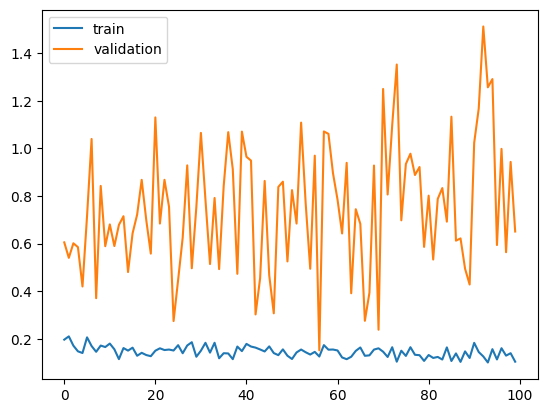

In [142]:
# Lists to store training and validation losses
t_losses, v_losses = [], []
# Loop over epochs
for epoch in range(n_epochs):
  train_loss, valid_loss = 0.0, 0.0

  # train step
  model.train()
  # Loop over train dataset
  for x, y in trainloader:
    # clear everything in optimizer
    optimizer.zero_grad()
    # move inputs to device
    x = x.to(device)
    y  = y.squeeze().to(device)
    # Forward Pass
    preds = model(x).squeeze()
    # calculate the loss
    loss = criterion(preds, y) 
    
    train_loss += loss.item()

    # backward propgation
    loss.backward()
    # change weight and bias
    optimizer.step()
  epoch_loss = train_loss / len(trainloader)
  t_losses.append(epoch_loss)
  
  # validation step
  model.eval()


  # Loop over validation dataset
  for x, y in testloader:
    with torch.no_grad():
      x, y = x.to(device), y.squeeze().to(device)
      preds = model(x).squeeze()
      error = criterion(preds, y)
    valid_loss += error.item()
  valid_loss = valid_loss / len(testloader)
  v_losses.append(valid_loss)
      
  print(f'loss=  {epoch} - train: {epoch_loss}, valid: {valid_loss}')
plot_losses(t_losses, v_losses)

In [145]:
def make_predictions_from_dataloader(model, dataloader):
  model.eval()
  predictions, actuals = [], []
  for x, y in dataloader:
    with torch.no_grad():
      p = model(x)
      #print(x.shape)
      predictions.append(p)
      actuals.append(y.squeeze())
  predictions = torch.cat(predictions).numpy()
  actuals = torch.cat(actuals).numpy()
  return predictions.squeeze(), actuals

In [146]:
full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
P, Y = make_predictions_from_dataloader(model, full_loader)
P.shape, Y.shape

((144,), (144,))

In [147]:
predictdf = pd.DataFrame([P, Y], index=['predictions', 'actuals']).T

fig = px.line(predictdf)
fig.update_layout(
    autosize=False,
    width=2400,
    height=800,)
fig.show()